In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file_path = r'C:/Users/anush/OneDrive/Documents/HAP880/mimic-iv-1.0/mimic4_1.db'
conn = sqlite3.connect(file_path)

In [4]:
adms = pd.read_sql("select * from admissions", conn )
icustays = pd.read_sql("select * from icustays ", conn )
patients = pd.read_sql("select * from patients", conn )

In [5]:
import time
adms['los_hrs'] = adms.apply(lambda r: (time.mktime(time.strptime(r['dischtime'],'%Y-%m-%d %H:%M:%S')) - 
                 time.mktime(time.strptime(r['admittime'],'%Y-%m-%d %H:%M:%S')))/3600.0, axis=1)

In [28]:
adms = adms[adms['discharge_location']!=""]

In [7]:
p = {'HOME HEALTH CARE': 0, 'HOME': 1, 'SKILLED NURSING FACILITY': 2, "DIED":3, 'REHAB': 4, 'CHRONIC/LONG TERM ACUTE CARE': 5, 'HOSPICE': 6, 'PSYCH FACILITY':7, 'AGAINST ADVICE':8,'ACUTE HOSPITAL':9,'OTHER FACILITY':10, 'ASSISTED LIVING':11, 'HEALTHCARE FACILITY':12}
adms['discharge_location'] = adms['discharge_location'].map(p)
d = {'EW EMER.': 0, 'URGENT': 1, 'OBSERVATION ADMIT': 2, "DIED":3, 'SURGICAL SAME DAY ADMISSION': 4, 'DIRECT EMER.': 5, 'ELECTIVE': 6, 'EU OBSERVATION':7, 'DIRECT OBSERVATION':8,'AMBULATORY OBSERVATION':9}
adms['admission_type'] = adms['admission_type'].map(d)
e = {'EMERGENCY ROOM': 0, 'PHYSICIAN REFERRAL': 1, 'TRANSFER FROM HOSPITAL': 2, "WALK-IN/SELF REFERRAL":3, 'TRANSFER FROM SKILLED NURSING FACILITY': 4, 'PROCEDURE SITE': 5, 'CLINIC REFERRAL': 6, 'PACU':7, 'INFORMATION NOT AVAILABLE':8,'AMBULATORY SURGERY TRANSFER':9,'INTERNAL TRANSFER TO OR FROM PSYCH':10}
adms['admission_location'] = adms['admission_location'].map(e)
i = {'Medical Intensive Care Unit (MICU)': 0, 'Medical/Surgical Intensive Care Unit (MICU/SICU)': 1, 'Cardiac Vascular Intensive Care Unit (CVICU)': 2, "Surgical Intensive Care Unit (SICU)":3, 'Trauma SICU (TSICU)': 4, 'Coronary Care Unit (CCU)': 5, 'Neuro Surgical Intensive Care Unit (Neuro SICU)': 6, 'Neuro Intermediate':7, 'Neuro Stepdown':8}
icustays['first_careunit'] = icustays['first_careunit'].map(i)
l = {'Medical Intensive Care Unit (MICU)': 0, 'Medical/Surgical Intensive Care Unit (MICU/SICU)': 1, 'Cardiac Vascular Intensive Care Unit (CVICU)': 2, "Surgical Intensive Care Unit (SICU)":3, 'Coronary Care Unit (CCU)': 4, 'Trauma SICU (TSICU)': 5, 'Neuro Intermediate':6, 'Neuro Stepdown':7,'Neuro Surgical Intensive Care Unit (Neuro SICU)':8}
icustays['last_careunit'] = icustays['last_careunit'].map(l)
m = {'SINGLE': 0, 'MARRIED': 1, 'WIDOWED': 2, "DIVORCED":3, '':4}
adms['marital_status'] = adms['marital_status'].map(m)
j = {'Other': 0, 'Medicare': 1, 'Medicaid':2}
adms['insurance'] = adms['insurance'].map(j)
g = {'M': 0, 'F': 1}
patients['gender'] = patients['gender'].map(g)
r = {'WHITE': 0, 'BLACK/AFRICAN AMERICAN': 1, 'UNKNOWN': 2, "OTHER":3, 'HISPANIC/LATINO':4,'ASIAN':5,'UNABLE TO OBTAIN':6,'AMERICAN INDIAN/ALASKA NATIVE':7}
adms['ethnicity'] = adms['ethnicity'].map(r)

<AxesSubplot:>

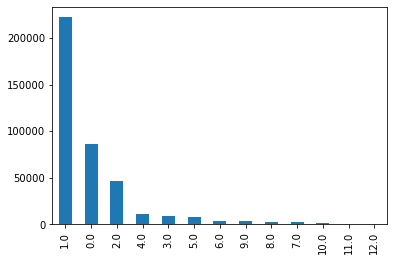

In [29]:
adms['discharge_location'].value_counts().plot(kind='bar')

In [8]:
patients['anchor_age'].astype(int)

0         23
1          0
2          0
3          0
4          0
          ..
382273    29
382274    52
382275    63
382276    33
382277    20
Name: anchor_age, Length: 382278, dtype: int32

In [9]:
conditions = [
    (patients['anchor_age'] >= '0') & (patients['anchor_age'] < '20'),
    (patients['anchor_age'] >= '20') & (patients['anchor_age'] < '40'),
    (patients['anchor_age'] >= '40') & (patients['anchor_age'] < '59'),
    (patients['anchor_age'] >= '60') &  (patients['anchor_age'] < '79'),
    (patients['anchor_age'] > '80')
]

values = ['0', '1', '2', '3','4']

patients['Age Group'] = np.select(conditions, values)

In [10]:
ids = pd.read_sql('select distinct hadm_id from inputevents',conn)['hadm_id'].values

In [11]:
def create_dummies(categorical):
    item_id = categorical['itemid'].iloc[0]
    dummies = pd.get_dummies(categorical['itemid']).sum()  
    dummies.index = [str(item_id)+"_"+str(col) for col in dummies.index]
    return dummies


In [12]:
def test_func(labs):
#     print('====')
    labs['totalamount'] = labs['totalamount'].apply(pd.to_numeric)
    labs_num = labs[labs['totalamount'].notna()]
    labs_cat = labs[labs['totalamount'].isna()]
#     print(labs.shape,labs_num.shape, labs_cat.shape) # to debug divide between cat and num
#     print(t)
    if labs_num.shape[0]>0:
    
        gr = labs_num.groupby('itemid')
        d_max = pd.DataFrame(gr['totalamount'].max()).T
        #d_mean  = pd.DataFrame(gr['totalamount'].mean()).T
        d_min = pd.DataFrame(gr['totalamount'].min()).T
        #d_sd = pd.DataFrame(gr['totalamount'].std()).T
        #d_s = pd.DataFrame(gr['totalamount'].count()).T
       # d_sd = d_sd.fillna('stdna')
        
        d_max.columns = [str(col)+"_max" for col in d_max.columns]
        #d_mean.columns = [str(col)+"_mean" for col in d_mean.columns]
        d_min.columns = [str(col)+"_min" for col in d_min.columns]
        #d_sd.columns = [str(col)+"_std" for col in d_sd.columns]
        #d_num = pd.concat([d_max,d_mean,d_min,d_sd,d_s], axis=1)
        d_num = pd.concat([d_max,d_min], axis=1)
        #d_sds.append(d_num)


    if labs_cat.shape[0] > 0:
        labs_cat_gr = labs_cat.groupby('itemid')
        te = labs_cat_gr.apply(create_dummies)
        d_cat = pd.DataFrame(te).T
        if len(d_cat.columns[0])==2:
            d_cat.columns = d_cat.columns.droplevel()           
        else:
            d_cat = d_cat.T
        d_cat.index = ['totalamount']

    if labs_cat.shape[0]>0 and labs_num.shape[0]>0:
        d = pd.concat([d_cat,d_num], axis=1)
    elif labs_cat.shape[0]>0:
        d = d_cat
    elif labs_num.shape[0]>0:
        d = d_num

    d['weight'] =labs['patientweight'].iloc[0]
    
    l = labs['hadm_id'][0]
    d['admission_location']= adms[adms['hadm_id']==l].iloc[0][6]
    d['discharge_location']= adms[adms['hadm_id']==l].iloc[0][7]
    d['admission_type']= adms[adms['hadm_id']==l].iloc[0][5]
    d['admission_type']= adms[adms['hadm_id']==l].iloc[0][5]
    d['insurance']= adms[adms['hadm_id']==l].iloc[0][8]
    #d['language']= adms[adms['hadm_id']==l].iloc[0][9]
    d['marital_status']= adms[adms['hadm_id']==l].iloc[0][10]
    d['ethnicity']= adms[adms['hadm_id']==l].iloc[0][11]
    d['los_hrs']= adms[adms['hadm_id']==l].iloc[0][15]
   # d['first_careunit']= icustays[icustays['hadm_id']==l].iloc[0][3]
   # d['last_careunit']= icustays[icustays['hadm_id']==l].iloc[0][4]
    
    m = labs['subject_id'][0]
    d['gender']= patients[patients['subject_id']==m].iloc[0][1]
    d['age_group']= patients[patients['subject_id']==m].iloc[0][6]
    
   # print(d['admission_location'])
    
    #d['admission_location']= adms['admission_location'].iloc[0]
    #d['discharge_location']=adms['discharge_location'].iloc[0]
   # d['admission_type']=adms['admission_type'].iloc[0]
   # d['insurance']=adms['insurance'].iloc[0]
    #print(details['insurance'].iloc[0])
    #d['first_careunit']=icustays['first_careunit'].iloc[0]
    #d['last_careunit']=icustays['last_careunit'].iloc[0]
   # d['marital_status']=adms['marital_status'].iloc[0]
    #d['insurance']=adms['insurance'].iloc[0]
    #d['gender']=patients['gender'].iloc[0]
    #d['ethnicity']=adms['ethnicity'].iloc[0]
    d['hadm_id']=labs['hadm_id'].iloc[0]
    
    return d


In [13]:
a = []
for id in ids:
    aa = pd.read_sql("select * from inputevents where hadm_id =  "+str(id), conn)
    ss = test_func(aa)
    a.append(ss)    
    

In [16]:
df = pd.concat(a)


In [26]:
df = df.set_index('hadm_id')

In [36]:
df = df.reset_index()

In [12]:
#df.reset_index(level =['hadm_id'], inplace = True)

In [ ]:
#df[df['hadm_id']=='20000094'].columns.tolist()

In [328]:
#pd.read_sql("select  itemid, count(*)  from inputevents where hadm_id = '20000094' group by itemid",conn)

In [329]:
#pd.read_sql("select  *  from inputevents where hadm_id = '20000094' and itemid = '226452'",conn)

In [37]:
final = df.fillna(0)

In [38]:
y=final['discharge_location']

In [40]:
cols=list(final.columns)

In [42]:
cols.remove('discharge_location')
cols.remove('hadm_id')

In [43]:
X=final[cols]

In [44]:
import pandas as pd
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import os
import io
from IPython.display import Image  
from six import StringIO  
import pydotplus
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold,cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, geom_col, geom_point
import plotnine as p9

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 200)

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68948 entries, 0 to 68947
Columns: 699 entries, 221385_221385 to 226875_min
dtypes: float64(692), int64(5), object(2)
memory usage: 367.7+ MB


In [52]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)

In [53]:
print("Accuracy for single train test split for decision tree:",metrics.accuracy_score(y_test, y_pred_tree))
print(metrics.classification_report(y_test, y_pred_tree))

Accuracy for single train test split for decision tree: 0.4072054301792655
              precision    recall  f1-score   support

         0.0       0.43      0.43      0.43      4585
         1.0       0.54      0.53      0.53      4287
         2.0       0.33      0.34      0.33      3167
         3.0       0.64      0.60      0.62      1924
         4.0       0.18      0.17      0.17      1334
         5.0       0.22      0.20      0.21      1078
         6.0       0.04      0.04      0.04       304
         7.0       0.12      0.11      0.12       185
         8.0       0.10      0.12      0.11       147
         9.0       0.05      0.04      0.05       140
        10.0       0.01      0.02      0.01        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.41     17237
   macro avg       0.20      0.20      0.20     17237
weighted avg       0.41      0.41      0.41     17237



In [59]:
clf_random =  RandomForestClassifier(n_estimators=10, 
                                     max_features=10,
                                     min_samples_split=2,
                                     criterion="entropy",
                                     random_state=10,
                                     n_jobs=-1)
clf_random = clf_random.fit(X_train,y_train)
y_pred_random = clf_random.predict(X_test)
print("Accuracy for random forest:",metrics.accuracy_score(y_test, y_pred_random))
print(metrics.classification_report(y_test, y_pred_random))

Accuracy for random forest: 0.4544294250739688
              precision    recall  f1-score   support

         0.0       0.41      0.55      0.47      4585
         1.0       0.51      0.67      0.58      4287
         2.0       0.35      0.29      0.32      3167
         3.0       0.67      0.61      0.64      1924
         4.0       0.32      0.13      0.18      1334
         5.0       0.35      0.16      0.22      1078
         6.0       0.00      0.00      0.00       304
         7.0       0.40      0.01      0.02       185
         8.0       0.17      0.01      0.01       147
         9.0       0.00      0.00      0.00       140
        10.0       0.00      0.00      0.00        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.45     17237
   macro avg       0.24      0.19      0.19     17237
weighted avg       0.43      0.45      0.43     17237



C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import SelectKBest
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
print("Accuracy for KNN at K =10:",metrics.accuracy_score(y_test, pred_knn))
print(metrics.classification_report(y_test, pred_knn))

Accuracy for KNN at K =10: 0.38544990427568604
              precision    recall  f1-score   support

         0.0       0.37      0.52      0.43      4585
         1.0       0.42      0.64      0.51      4287
         2.0       0.26      0.21      0.23      3167
         3.0       0.59      0.35      0.43      1924
         4.0       0.27      0.09      0.14      1334
         5.0       0.30      0.08      0.13      1078
         6.0       0.20      0.01      0.02       304
         7.0       0.00      0.00      0.00       185
         8.0       0.50      0.01      0.01       147
         9.0       0.00      0.00      0.00       140
        10.0       0.00      0.00      0.00        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.39     17237
   macro avg       0.22      0.15      0.15     17237
weighted avg       0.37      0.39      0.35     17237



C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [61]:
print(confusion_matrix(y_test,pred_knn))

[[2381 1489  531   88   58   35    1    2    0    0    0    0    0]
 [1110 2733  319   43   62   15    1    4    0    0    0    0    0]
 [1386  910  650  101   76   43    1    0    0    0    0    0    0]
 [ 487  308  325  664   60   75    5    0    0    0    0    0    0]
 [ 443  421  247   63  121   35    3    0    1    0    0    0    0]
 [ 350  196  259  123   57   91    1    1    0    0    0    0    0]
 [  92  103   64   24   11    7    3    0    0    0    0    0    0]
 [  47  116   14    6    2    0    0    0    0    0    0    0    0]
 [  24  103   13    5    1    0    0    0    1    0    0    0    0]
 [  48   55   18   10    6    3    0    0    0    0    0    0    0]
 [  16   34   11    3    2    0    0    0    0    0    0    0    0]
 [   6    9    2    2    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0]]


In [62]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
 

In [63]:
trf_preproc = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=np.integer))
)
clf_gaussian = make_pipeline(trf_preproc,GaussianNB())
clf_gaussian.fit(X_train, y_train)
y_pred_gaussian = clf_gaussian.predict(X_test)

In [64]:
print("Accuracy for NaiveBayes:",metrics.accuracy_score(y_test, y_pred_gaussian))

Accuracy for NaiveBayes: 0.19591576260370133


In [65]:
clf_multinomial = make_pipeline(trf_preproc, MultinomialNB())
clf_multinomial.fit(X_train, y_train)
y_pred_multi = clf_multinomial.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_multi))

Accuracy: 0.27458374427104487


In [66]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(solver="lbfgs", multi_class="ovr")
clf.fit(X_train, y_train)
y_logistic = clf.predict(X_test)
print("Accuracy of logistic regression:",metrics.accuracy_score(y_test, y_logistic))

C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\skl

Accuracy of logistic regression: 0.4590706039333991


In [67]:
print(metrics.classification_report(y_test, y_logistic))

              precision    recall  f1-score   support

         0.0       0.44      0.47      0.46      4585
         1.0       0.45      0.79      0.57      4287
         2.0       0.32      0.21      0.25      3167
         3.0       0.76      0.67      0.71      1924
         4.0       0.33      0.12      0.18      1334
         5.0       0.43      0.23      0.30      1078
         6.0       0.00      0.00      0.00       304
         7.0       0.29      0.04      0.08       185
         8.0       0.00      0.00      0.00       147
         9.0       0.00      0.00      0.00       140
        10.0       0.00      0.00      0.00        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.46     17237
   macro avg       0.23      0.20      0.20     17237
weighted avg       0.43      0.46      0.42     17237



### Using information gain to select important features

In [68]:
from sklearn.feature_selection import mutual_info_classif

In [72]:
importances = mutual_info_classif(X, y)

In [73]:
feature_imp = pd.Series(importances,X.columns[0:len(X.columns)])

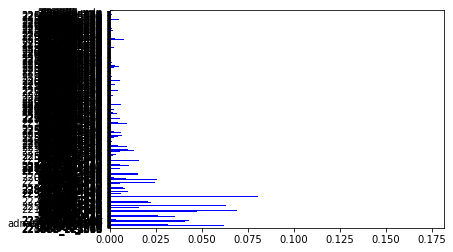

In [74]:
feature_imp.plot(kind = 'barh', color = 'blue')
plt.show()

In [75]:
list_of_attr = feature_imp.sort_values(ascending=False)

In [76]:
Attr = pd.DataFrame(list_of_attr)

In [78]:
Attr.reset_index(inplace=True)


In [80]:
Attr = Attr.rename(columns={Attr.columns[1]: 'Value'})

In [90]:
Attr[Attr['Value']>0.04]

,index,Value
0,los_hrs,0.173269
1,age_group,0.097254
2,220949_max,0.085401
3,226452_min,0.084885
4,220949_min,0.080990
5,226453_max,0.080567
6,225799_min,0.078632
7,226453_min,0.076583
8,225799_max,0.076569
9,226452_max,0.072873


In [221]:
pd.read_sql("select * from d_items where itemid in ('220949','226452','226453','225799','226452','225154','221906','225158','223258')", conn)

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220949,Dextrose 5%,Dextrose 5%,inputevents,Fluids/Intake,mL,Solution,,
1,221906,Norepinephrine,Norepinephrine,inputevents,Medications,mg,Solution,,
2,223258,Insulin - Regular,Insulin - Regular,inputevents,Medications,units,Solution,,
3,225154,Morphine Sulfate,Morphine Sulfate,inputevents,Medications,mg,Solution,,
4,225158,NaCl 0.9%,NaCl 0.9%,inputevents,Fluids/Intake,mL,Solution,,
5,225799,Gastric Meds,Gastric Meds,inputevents,Fluids/Intake,mL,Solution,,
6,226452,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,,
7,226453,GT Flush,GT Flush,inputevents,Fluids/Intake,mL,Solution,,


In [88]:
final_attributes = Attr[Attr['Value']>0.04]

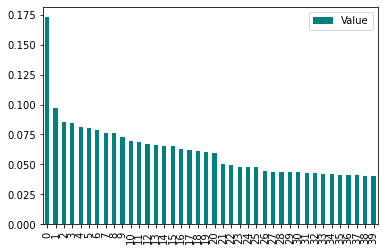

In [89]:
final_attributes.plot(kind = 'bar', color = 'teal')
plt.show()

In [91]:
columns = final_attributes['index'].tolist()

In [92]:
X_feat = final[columns]

In [93]:
feat_y = final['discharge_location']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, feat_y, test_size=0.25, random_state = 200)

In [95]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
print("Post feature selection - Accuracy for single train test split for decision tree:",metrics.accuracy_score(y_test, y_pred_tree))
print(metrics.classification_report(y_test, y_pred_tree))

Post feature selection - Accuracy for single train test split for decision tree: 0.39426814410860356
              precision    recall  f1-score   support

         0.0       0.42      0.41      0.41      4585
         1.0       0.53      0.53      0.53      4287
         2.0       0.32      0.32      0.32      3167
         3.0       0.63      0.59      0.61      1924
         4.0       0.17      0.18      0.17      1334
         5.0       0.22      0.22      0.22      1078
         6.0       0.03      0.04      0.04       304
         7.0       0.06      0.07      0.07       185
         8.0       0.09      0.11      0.10       147
         9.0       0.03      0.03      0.03       140
        10.0       0.03      0.03      0.03        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.39     17237
   macro avg       0.19      0.19      0.19     17237
weighted avg       0.40      0.39

In [97]:
clf_random =  RandomForestClassifier(n_estimators=10, 
                                     max_features=10,
                                     min_samples_split=2,
                                     criterion="entropy",
                                     random_state=10,
                                     n_jobs=-1)
clf_random = clf_random.fit(X_train,y_train)
y_pred_random = clf_random.predict(X_test)
print(" Post Featuer Selection  - Accuracy for random forest:",metrics.accuracy_score(y_test, y_pred_random))
print(metrics.classification_report(y_test, y_pred_random))

 Post Featuer Selection  - Accuracy for random forest: 0.4808841445727215
              precision    recall  f1-score   support

         0.0       0.44      0.55      0.49      4585
         1.0       0.56      0.67      0.61      4287
         2.0       0.37      0.39      0.38      3167
         3.0       0.74      0.63      0.68      1924
         4.0       0.24      0.12      0.17      1334
         5.0       0.35      0.23      0.28      1078
         6.0       0.06      0.01      0.01       304
         7.0       0.11      0.01      0.02       185
         8.0       0.13      0.02      0.04       147
         9.0       0.00      0.00      0.00       140
        10.0       0.00      0.00      0.00        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.48     17237
   macro avg       0.23      0.20      0.21     17237
weighted avg       0.45      0.48      0.46     17237



C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [98]:
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
print("Post Featuer Selection - Accuracy for KNN at K =10:",metrics.accuracy_score(y_test, pred_knn))
print(metrics.classification_report(y_test, pred_knn))

Post Featuer Selection - Accuracy for KNN at K =10: 0.4077855775366943
              precision    recall  f1-score   support

         0.0       0.39      0.53      0.45      4585
         1.0       0.46      0.62      0.52      4287
         2.0       0.26      0.21      0.23      3167
         3.0       0.64      0.52      0.57      1924
         4.0       0.24      0.11      0.15      1334
         5.0       0.31      0.16      0.21      1078
         6.0       0.00      0.00      0.00       304
         7.0       0.14      0.01      0.01       185
         8.0       0.00      0.00      0.00       147
         9.0       0.00      0.00      0.00       140
        10.0       0.00      0.00      0.00        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.41     17237
   macro avg       0.19      0.16      0.16     17237
weighted avg       0.38      0.41      0.38     17237



C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [99]:
trf_preproc = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=np.integer))
)
clf_gaussian = make_pipeline(trf_preproc,GaussianNB())
clf_gaussian.fit(X_train, y_train)
y_pred_gaussian = clf_gaussian.predict(X_test)
print("Post Feature Selection - Accuracy for NaiveBayes:",metrics.accuracy_score(y_test, y_pred_gaussian))

Post Feature Selection - Accuracy for NaiveBayes: 0.3147299414051169


In [100]:
clf_multinomial = make_pipeline(trf_preproc, MultinomialNB())
clf_multinomial.fit(X_train, y_train)
y_pred_multi = clf_multinomial.predict(X_test)
print("Post Feature Selection - Multi nomial NB Accuracy:",metrics.accuracy_score(y_test, y_pred_multi))

Post Feature Selection - Multi nomial NB Accuracy: 0.267331902303185


In [101]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(solver="lbfgs", multi_class="ovr")
clf.fit(X_train, y_train)
y_logistic = clf.predict(X_test)
print("Post Feature Selection - Accuracy of logistic regression:",metrics.accuracy_score(y_test, y_logistic))
print(metrics.classification_report(y_test, y_logistic))

C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\skl

Post Feature Selection - Accuracy of logistic regression: 0.43447235597841855
              precision    recall  f1-score   support

         0.0       0.41      0.50      0.45      4585
         1.0       0.45      0.72      0.55      4287
         2.0       0.28      0.18      0.22      3167
         3.0       0.69      0.62      0.65      1924
         4.0       0.23      0.06      0.09      1334
         5.0       0.39      0.22      0.28      1078
         6.0       0.00      0.00      0.00       304
         7.0       0.00      0.00      0.00       185
         8.0       0.00      0.00      0.00       147
         9.0       0.00      0.00      0.00       140
        10.0       0.00      0.00      0.00        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.43     17237
   macro avg       0.19      0.18      0.17     17237
weighted avg       0.39      0.43      0.40     17237



C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\

In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [103]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.419
Accuracy score (validation): 0.414
Learning rate:  0.075
Accuracy score (training): 0.437
Accuracy score (validation): 0.432
Learning rate:  0.1
Accuracy score (training): 0.445
Accuracy score (validation): 0.439
Learning rate:  0.25
Accuracy score (training): 0.475
Accuracy score (validation): 0.474
Learning rate:  0.5
Accuracy score (training): 0.489
Accuracy score (validation): 0.486
Learning rate:  0.75
Accuracy score (training): 0.177
Accuracy score (validation): 0.176
Learning rate:  1
Accuracy score (training): 0.172
Accuracy score (validation): 0.174


In [104]:
#highest learning rate at 0.25
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

In [105]:
print("Confusion Matrix for Gradient Boost:")
print(confusion_matrix(y_test, predictions))

print("Classification Report for Gradient Boost")
print(classification_report(y_test, predictions))

Confusion Matrix for Gradient Boost:
[[2559 1206  564   71   86   81    1    5    5    1    3    0    3]
 [ 777 3129  226   36   76   27    0    7    6    0    0    0    3]
 [1292  466 1019  107  117  155    1    4    1    1    0    0    4]
 [ 189  131  234 1185   36  146    0    0    1    0    2    0    0]
 [ 341  326  299   41  173  147    1    2    1    0    0    0    3]
 [ 235  102  261   75   91  306    2    2    0    1    0    0    3]
 [  96   70   69   33    5   31    0    0    0    0    0    0    0]
 [  14  142    9    2    4    3    0    9    2    0    0    0    0]
 [  12  114    9    6    2    0    0    2    1    1    0    0    0]
 [  33   54   23   16    6    7    0    0    0    1    0    0    0]
 [  16   37    5    5    1    2    0    0    0    0    0    0    0]
 [   4    6    6    1    1    1    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0]]
Classification Report for Gradient Boost
              precision    recall  f1

C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


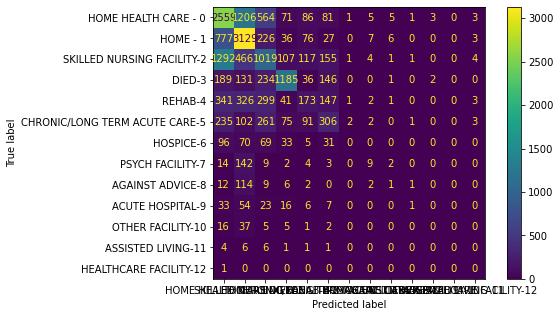

In [106]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, predictions),
    display_labels=['HOME HEALTH CARE - 0', 'HOME - 1', 'SKILLED NURSING FACILITY-2', 'DIED-3', 'REHAB-4', 'CHRONIC/LONG TERM ACUTE CARE-5', 'HOSPICE-6', 'PSYCH FACILITY-7', 'AGAINST ADVICE-8','ACUTE HOSPITAL-9','OTHER FACILITY-10', 'ASSISTED LIVING-11', 'HEALTHCARE FACILITY-12'],
)

cmp.plot(ax=ax)
plt.show();

### Feature Importance based on Random Forest

In [107]:
imprf=pd.DataFrame([Attr['index'].tolist(),clf_random.feature_importances_]).T

In [108]:
feat_rf = imprf.sort_values(1, ascending=False)

In [109]:
feat_rf = feat_rf.rename(columns={feat_rf.columns[0]: 'Attribute',feat_rf.columns[1]: 'Value'})

In [111]:
features_rf = feat_rf[feat_rf['Value'] >= 0]

In [222]:
features_rf

,Attribute,Value
0,los_hrs,0.149505
9,226452_max,0.064276
1,age_group,0.056758
3,226452_min,0.051596
13,225158_min,0.039237
2,220949_max,0.036947
30,marital_status,0.034937
31,admission_type,0.034527
19,225158_max,0.034391
38,225975_225975,0.033578


In [527]:
#Models based on feature selection from random forest

In [112]:
X_rf_feat = final[features_rf['Attribute'].tolist()]

In [113]:
rf_feat_y = final['discharge_location']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_rf_feat, rf_feat_y, test_size=0.25, random_state = 200)

In [115]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
print("Post RF feature selection - Accuracy for single train test split for decision tree:",metrics.accuracy_score(y_test, y_pred_tree))
print(metrics.classification_report(y_test, y_pred_tree))

Post RF feature selection - Accuracy for single train test split for decision tree: 0.4003596913616059
              precision    recall  f1-score   support

         0.0       0.43      0.42      0.42      4585
         1.0       0.53      0.53      0.53      4287
         2.0       0.33      0.33      0.33      3167
         3.0       0.63      0.58      0.61      1924
         4.0       0.17      0.18      0.18      1334
         5.0       0.22      0.21      0.22      1078
         6.0       0.03      0.04      0.04       304
         7.0       0.07      0.09      0.08       185
         8.0       0.09      0.11      0.10       147
         9.0       0.02      0.02      0.02       140
        10.0       0.01      0.02      0.02        66
        11.0       0.00      0.00      0.00        19
        12.0       0.00      0.00      0.00         1

    accuracy                           0.40     17237
   macro avg       0.20      0.19      0.19     17237
weighted avg       0.41      0.

In [116]:
clf_random =  RandomForestClassifier(n_estimators=10, 
                                     max_features=10,
                                     min_samples_split=2,
                                     criterion="entropy",
                                     random_state=10,
                                     n_jobs=-1)
clf_random = clf_random.fit(X_train,y_train)
y_pred_random = clf_random.predict(X_test)
print(" Post RF Featuer Selection  - Accuracy for random forest:",metrics.accuracy_score(y_test, y_pred_random))

 Post RF Featuer Selection  - Accuracy for random forest: 0.4848291466032372


In [117]:
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
print("Post RF Featuer Selection - Accuracy for KNN at K =10:",metrics.accuracy_score(y_test, pred_knn))

Post RF Featuer Selection - Accuracy for KNN at K =10: 0.4077855775366943


In [118]:
trf_preproc = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=np.integer))
)
clf_gaussian = make_pipeline(trf_preproc,GaussianNB())
clf_gaussian.fit(X_train, y_train)
y_pred_gaussian = clf_gaussian.predict(X_test)
print("Post RF Feature Selection - Accuracy for NaiveBayes:",metrics.accuracy_score(y_test, y_pred_gaussian))

Post RF Feature Selection - Accuracy for NaiveBayes: 0.3147299414051169


In [119]:
clf_multinomial = make_pipeline(trf_preproc, MultinomialNB())
clf_multinomial.fit(X_train, y_train)
y_pred_multi = clf_multinomial.predict(X_test)
print("Post RF Feature Selection - Multi nomial NB Accuracy:",metrics.accuracy_score(y_test, y_pred_multi))

Post RF Feature Selection - Multi nomial NB Accuracy: 0.267331902303185


In [120]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(solver="lbfgs", multi_class="ovr")
clf.fit(X_train, y_train)
y_logistic = clf.predict(X_test)
print("Post RF Feature Selection - Accuracy of logistic regression:",metrics.accuracy_score(y_test, y_logistic))

C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\skl

Post RF Feature Selection - Accuracy of logistic regression: 0.4341822822997041


C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [121]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)
print("Confusion Matrix for Gradient Boost:")
print(confusion_matrix(y_test, predictions))

print("Classification Report for Gradient Boost")
print(classification_report(y_test, predictions))

Confusion Matrix for Gradient Boost:
[[2637 1179  540   84   61   74    0    5    0    1    3    1    0]
 [ 788 3153  199   50   63   26    0    2    0    1    3    2    0]
 [1197  400 1212  138   65  150    1    3    0    0    0    1    0]
 [ 153  134  267 1198   34  132    1    2    0    1    1    1    0]
 [ 407  300  282   49  174  117    0    2    0    0    0    3    0]
 [ 249   99  255  111   97  262    0    2    0    1    1    1    0]
 [  71   67  102   29    6   27    0    0    0    0    1    1    0]
 [   9  145    6    2    3    9    0   11    0    0    0    0    0]
 [  12  118    8    4    1    1    0    1    1    1    0    0    0]
 [  34   53   23   15    8    7    0    0    0    0    0    0    0]
 [  11   41    5    5    2    2    0    0    0    0    0    0    0]
 [   3    3   12    0    1    0    0    0    0    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0    0    0    0    0]]
Classification Report for Gradient Boost
              precision    recall  f1

C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\anush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [122]:
print("Post RF Feature Selection - Accuracy of gradeint boost:",metrics.accuracy_score(y_test, predictions))

Post RF Feature Selection - Accuracy of gradeint boost: 0.5017114347044149


In [123]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.424
Accuracy score (validation): 0.419
Learning rate:  0.075
Accuracy score (training): 0.443
Accuracy score (validation): 0.439
Learning rate:  0.1
Accuracy score (training): 0.455
Accuracy score (validation): 0.452
Learning rate:  0.25
Accuracy score (training): 0.492
Accuracy score (validation): 0.490
Learning rate:  0.5
Accuracy score (training): 0.504
Accuracy score (validation): 0.502
Learning rate:  0.75
Accuracy score (training): 0.087
Accuracy score (validation): 0.087
Learning rate:  1
Accuracy score (training): 0.076
Accuracy score (validation): 0.072


### Balance the dataset 

<AxesSubplot:>

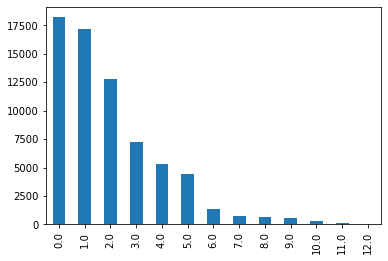

In [192]:
y.value_counts().plot(kind='bar')

In [202]:
X=final[cols]

In [203]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

Y = LabelEncoder().fit_transform(y)

In [204]:
oversample = SMOTE()

In [205]:
X, Y = oversample.fit_resample(X, Y)

Class=3, n=18204 (7.692%)
Class=2, n=18204 (7.692%)
Class=7, n=18204 (7.692%)
Class=1, n=18204 (7.692%)
Class=0, n=18204 (7.692%)
Class=5, n=18204 (7.692%)
Class=4, n=18204 (7.692%)
Class=8, n=18204 (7.692%)
Class=6, n=18204 (7.692%)
Class=9, n=18204 (7.692%)
Class=11, n=18204 (7.692%)
Class=10, n=18204 (7.692%)
Class=12, n=18204 (7.692%)


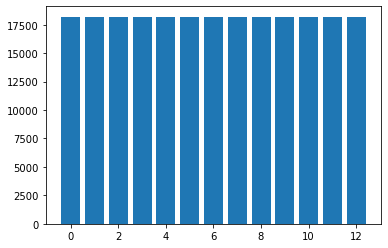

In [206]:
counter = Counter(Y)
for k,v in counter.items():
    per = v / len(Y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 200)

In [208]:
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
print("Post balancing the data - Accuracy for single train test split for decision tree:",metrics.accuracy_score(y_test, y_pred_tree))
print(metrics.classification_report(y_test, y_pred_tree))

Post balancing the data - Accuracy for single train test split for decision tree: 0.7002349441373832
              precision    recall  f1-score   support

           0       0.42      0.43      0.42      4549
           1       0.50      0.48      0.49      4530
           2       0.34      0.34      0.34      4605
           3       0.72      0.66      0.69      4517
           4       0.48      0.46      0.47      4616
           5       0.54      0.51      0.53      4566
           6       0.68      0.71      0.70      4491
           7       0.86      0.88      0.87      4532
           8       0.86      0.89      0.87      4608
           9       0.80      0.84      0.82      4521
          10       0.89      0.94      0.91      4505
          11       0.96      0.99      0.98      4580
          12       1.00      1.00      1.00      4543

    accuracy                           0.70     59163
   macro avg       0.70      0.70      0.70     59163
weighted avg       0.70      0.70

In [209]:
clf_random =  RandomForestClassifier(n_estimators=10, 
                                     max_features=10,
                                     min_samples_split=2,
                                     criterion="entropy",
                                     random_state=10,
                                     n_jobs=-1)
clf_random = clf_random.fit(X_train,y_train)
y_pred_random = clf_random.predict(X_test)
print(" Post  balancing the data  - Accuracy for random forest:",metrics.accuracy_score(y_test, y_pred_random))
print(metrics.classification_report(y_test, y_pred_random))

 Post  balancing the data  - Accuracy for random forest: 0.7875192265436168
              precision    recall  f1-score   support

           0       0.41      0.51      0.45      4549
           1       0.52      0.60      0.56      4530
           2       0.44      0.36      0.40      4605
           3       0.76      0.78      0.77      4517
           4       0.69      0.60      0.65      4616
           5       0.73      0.66      0.69      4566
           6       0.88      0.87      0.87      4491
           7       0.94      0.98      0.96      4532
           8       0.96      0.97      0.97      4608
           9       0.97      0.95      0.96      4521
          10       0.99      0.98      0.99      4505
          11       1.00      1.00      1.00      4580
          12       1.00      1.00      1.00      4543

    accuracy                           0.79     59163
   macro avg       0.79      0.79      0.79     59163
weighted avg       0.79      0.79      0.79     59163



In [210]:
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
print("Post balancing the data - Accuracy for KNN at K =10:",metrics.accuracy_score(y_test, pred_knn))
print(metrics.classification_report(y_test, pred_knn))

Post balancing the data - Accuracy for KNN at K =10: 0.738045738045738
              precision    recall  f1-score   support

           0       0.48      0.26      0.34      4549
           1       0.48      0.30      0.37      4530
           2       0.42      0.25      0.31      4605
           3       0.75      0.63      0.68      4517
           4       0.60      0.62      0.61      4616
           5       0.68      0.70      0.69      4566
           6       0.71      0.95      0.81      4491
           7       0.76      0.97      0.85      4532
           8       0.78      0.97      0.86      4608
           9       0.81      0.97      0.89      4521
          10       0.84      0.98      0.91      4505
          11       0.92      1.00      0.95      4580
          12       0.97      1.00      0.99      4543

    accuracy                           0.74     59163
   macro avg       0.71      0.74      0.71     59163
weighted avg       0.71      0.74      0.71     59163



In [211]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(solver="lbfgs", multi_class="ovr")
clf.fit(X_train, y_train)
y_logistic = clf.predict(X_test)
print("Post balancing the data - Accuracy of logistic regression:",metrics.accuracy_score(y_test, y_logistic))
print(metrics.classification_report(y_test, y_logistic))

C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\anush\anaconda3\lib\site-packages\skl

Post balancing the data - Accuracy of logistic regression: 0.44140763652958775
              precision    recall  f1-score   support

           0       0.41      0.29      0.34      4549
           1       0.28      0.28      0.28      4530
           2       0.24      0.07      0.11      4605
           3       0.72      0.69      0.70      4517
           4       0.38      0.32      0.35      4616
           5       0.44      0.38      0.41      4566
           6       0.35      0.32      0.34      4491
           7       0.42      0.60      0.50      4532
           8       0.41      0.48      0.45      4608
           9       0.37      0.24      0.29      4521
          10       0.33      0.34      0.33      4505
          11       0.38      0.76      0.51      4580
          12       0.81      0.98      0.89      4543

    accuracy                           0.44     59163
   macro avg       0.43      0.44      0.42     59163
weighted avg       0.43      0.44      0.42     59163



In [212]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.265
Accuracy score (validation): 0.263
Learning rate:  0.075
Accuracy score (training): 0.268
Accuracy score (validation): 0.266
Learning rate:  0.1
Accuracy score (training): 0.269
Accuracy score (validation): 0.268
Learning rate:  0.25
Accuracy score (training): 0.284
Accuracy score (validation): 0.283
Learning rate:  0.5
Accuracy score (training): 0.294
Accuracy score (validation): 0.291
Learning rate:  0.75
Accuracy score (training): 0.303
Accuracy score (validation): 0.300
Learning rate:  1
Accuracy score (training): 0.304
Accuracy score (validation): 0.299


In [213]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)
print("Post balancing the data - Accuracy of gradeint boost:",metrics.accuracy_score(y_test, predictions))

Post balancing the data - Accuracy of gradeint boost: 0.298649493771445


### On ICU Patients

In [219]:
def test_func(labs):
#     print('====')
    labs['totalamount'] = labs['totalamount'].apply(pd.to_numeric)
    labs_num = labs[labs['totalamount'].notna()]
    labs_cat = labs[labs['totalamount'].isna()]
#     print(labs.shape,labs_num.shape, labs_cat.shape) # to debug divide between cat and num
#     print(t)
    if labs_num.shape[0]>0:
    
        gr = labs_num.groupby('itemid')
        d_max = pd.DataFrame(gr['totalamount'].max()).T
        #d_mean  = pd.DataFrame(gr['totalamount'].mean()).T
        d_min = pd.DataFrame(gr['totalamount'].min()).T
        #d_sd = pd.DataFrame(gr['totalamount'].std()).T
        #d_s = pd.DataFrame(gr['totalamount'].count()).T
       # d_sd = d_sd.fillna('stdna')
        
        d_max.columns = [str(col)+"_max" for col in d_max.columns]
        #d_mean.columns = [str(col)+"_mean" for col in d_mean.columns]
        d_min.columns = [str(col)+"_min" for col in d_min.columns]
        #d_sd.columns = [str(col)+"_std" for col in d_sd.columns]
        #d_num = pd.concat([d_max,d_mean,d_min,d_sd,d_s], axis=1)
        d_num = pd.concat([d_max,d_min], axis=1)
        #d_sds.append(d_num)


    if labs_cat.shape[0] > 0:
        labs_cat_gr = labs_cat.groupby('itemid')
        te = labs_cat_gr.apply(create_dummies)
        d_cat = pd.DataFrame(te).T
        if len(d_cat.columns[0])==2:
            d_cat.columns = d_cat.columns.droplevel()           
        else:
            d_cat = d_cat.T
        d_cat.index = ['totalamount']

    if labs_cat.shape[0]>0 and labs_num.shape[0]>0:
        d = pd.concat([d_cat,d_num], axis=1)
    elif labs_cat.shape[0]>0:
        d = d_cat
    elif labs_num.shape[0]>0:
        d = d_num

    d['weight'] =labs['patientweight'].iloc[0]
    
    l = labs['hadm_id'][0]
    d['admission_location']= adms[adms['hadm_id']==l].iloc[0][6]
    d['discharge_location']= adms[adms['hadm_id']==l].iloc[0][7]
    d['admission_type']= adms[adms['hadm_id']==l].iloc[0][5]
    d['admission_type']= adms[adms['hadm_id']==l].iloc[0][5]
    d['insurance']= adms[adms['hadm_id']==l].iloc[0][8]
    #d['language']= adms[adms['hadm_id']==l].iloc[0][9]
    d['marital_status']= adms[adms['hadm_id']==l].iloc[0][10]
    d['ethnicity']= adms[adms['hadm_id']==l].iloc[0][11]
    d['los_hrs']= adms[adms['hadm_id']==l].iloc[0][15]
    d['first_careunit']= icustays[icustays['hadm_id']==l].iloc[0][3]
    d['last_careunit']= icustays[icustays['hadm_id']==l].iloc[0][4]
    
    m = labs['subject_id'][0]
    d['gender']= patients[patients['subject_id']==m].iloc[0][1]
    d['age_group']= patients[patients['subject_id']==m].iloc[0][6]
    
   # print(d['admission_location'])
    
    #d['admission_location']= adms['admission_location'].iloc[0]
    #d['discharge_location']=adms['discharge_location'].iloc[0]
   # d['admission_type']=adms['admission_type'].iloc[0]
   # d['insurance']=adms['insurance'].iloc[0]
    #print(details['insurance'].iloc[0])
    #d['first_careunit']=icustays['first_careunit'].iloc[0]
    #d['last_careunit']=icustays['last_careunit'].iloc[0]
   # d['marital_status']=adms['marital_status'].iloc[0]
    #d['insurance']=adms['insurance'].iloc[0]
    #d['gender']=patients['gender'].iloc[0]
    #d['ethnicity']=adms['ethnicity'].iloc[0]
    d['hadm_id']=labs['hadm_id'].iloc[0]
    
    return d


In [214]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
X = X_rf_feat
y= rf_feat_y

In [215]:
y = label_binarize(Y, classes=[0, 1, 2,3,4,5,6,7,8,9,10,11,12])
n_classes = y.shape[1]

In [216]:
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

MemoryError: Unable to allocate 246. GiB for an array with shape (236652, 139800) and data type float64

In [582]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


In [584]:
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)



In [585]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

C:\Users\anush\anaconda3\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 12 is present in all training examples.


In [586]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [587]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [588]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [589]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

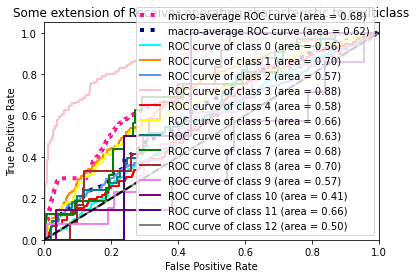

In [599]:
lw=2
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","pink","red","yellow","teal","green","brown","violet","purple","indigo","grey"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 5], [0, 5], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [18]:
adms["admittime"] = pd.to_datetime(adms.admittime)
adms["dischtime"] = pd.to_datetime(adms.dischtime)


In [19]:
adms["los"] = adms["dischtime"] - adms["admittime"]

In [21]:
los_count = adms.groupby(adms['los'].dt.days).los.count()

In [35]:
cormat = details.corr()
round(cormat,2)

,admission_type,admission_location,insurance,marital_status,ethnicity,first_careunit,last_careunit,gender
admission_type,1.00,0.18,0.05,-0.02,-0.03,0.14,0.13,-0.01
admission_location,0.18,1.00,0.01,0.04,0.02,0.09,0.07,-0.02
insurance,0.05,0.01,1.00,-0.07,0.09,0.04,0.05,-0.06
marital_status,-0.02,0.04,-0.07,1.00,0.11,0.06,0.07,0.06
ethnicity,-0.03,0.02,0.09,0.11,1.00,0.00,0.01,-0.01
first_careunit,0.14,0.09,0.04,0.06,0.00,1.00,0.89,-0.00
last_careunit,0.13,0.07,0.05,0.07,0.01,0.89,1.00,-0.01
gender,-0.01,-0.02,-0.06,0.06,-0.01,-0.00,-0.01,1.00


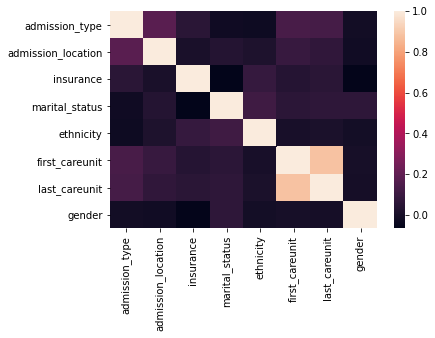

In [36]:
import seaborn as sns
sns.heatmap(cormat);

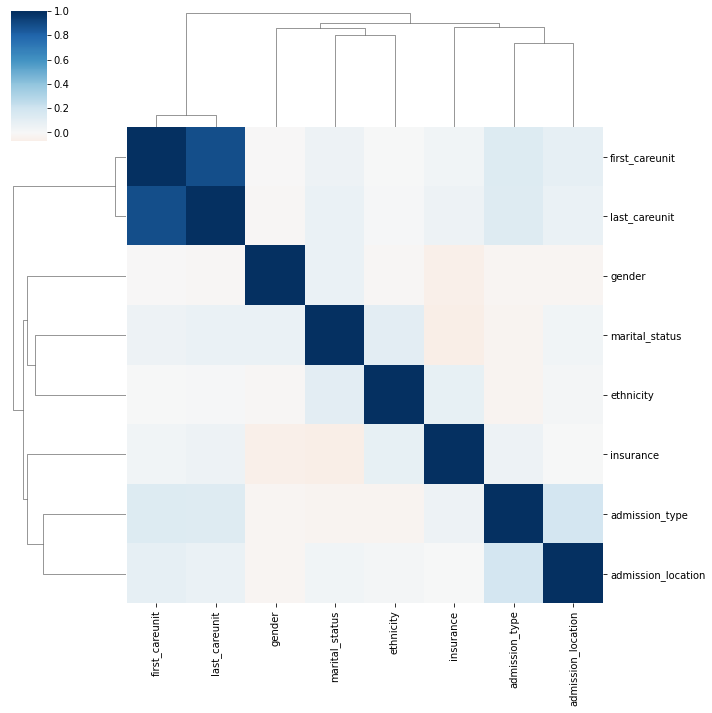

In [37]:
sns.clustermap(cormat, cmap='RdBu',center=0)

In [ ]:
items_sort = itemss.sort_values(by=['count(*)'],ascending=False)

In [ ]:
items_sort_s = items_sort[items_sort['count(*)']<=100]
plt.plot(items_sort_s['itemid'],items_sort_s['count(*)'])

In [ ]:
plt.plot(items_sort['itemid'],items_sort['count(*)']/100000)